# Generate Image Patches

In this demo we will show how to transform a given image into a series of patches able to cover the entire image.
This is a mandatory step for the creation of the dataset described in the work of Curti et al. [1](TODO).

Despite its simplicity in terms of single image, we need to pay a particular attention when we work with pair of data given by image + mask.
The creation of a good image patchifier, indeed, will allow the re-organization of the original image without loosing information and correctly combine the predictions of the segmentation models.

In the code below we will create a custom object used for the generation of a series of patches, giving priority to its usability than computational efficiency.
First of all, let's load a sample image.

Image shape: (1032, 1376)
Image fmt: uint8


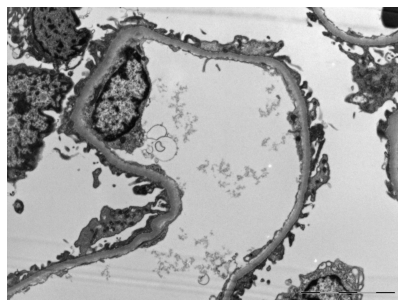

In [1]:
import numpy as np
import pylab as plt

# declare a filename
filename = 'image.tif'

# load it into a numpy array
img = plt.imread(filename)
# convert it to a simple grayscale
img = img[..., 0]

print(f'Image shape: {img.shape}')
print(f'Image fmt: {img.dtype}')

# display it
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
_ = ax.imshow(img, cmap='gray')
_ = ax.axis('off')

Now we will create an image patchifier able to transform the given image (grayscale or RGB) into a series of overlapping patches, given the patch-size and patch-stride.
With the inverse_transform the series of patches (eventually processed) can be rebuilt using the average of overlapping values.
For sake of completeness, since this procedure mimic exactly the `sklearn` interface, we will create an *ad hoc* transformer compatible with this philosophy.

In [2]:
import itertools
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.utils import check_X_y
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

class Patchifier (BaseEstimator, TransformerMixin):
    '''
    Image patchifier
    
    Transform the given image (grayscale or RGB) into a 
    series of [overlapping] patches, given the patch-size
    and patch-stride.
    With the inverse_transform the series of patches
    (eventually processed) can be rebuilt using the average
    of overlapping values.
    
    Parameters
    ----------
    size : tuple
        Patch dimension as (size_x, size_y)
    
    stride : tuple
        Patch stride as (stride_x, stride_y)
        The stride determines the number of overlapping pixels
        to consider in patches subdivision
    
    pad : bool
        Enable/Disable padding before the patches subdivision
        With padding enable we can ensure that all the image
        is considered into patches subdivision.
        With padding disable only the maximum subset of patches
        is extracted.    
    '''
    
    def __init__ (self, size : tuple, stride : tuple, 
                  pad : bool = True):
        
        self.size = size

        if not hasattr(self.size, '__iter__'):
            self.size = (int(self.size), int(self.size))

        if self.size[0] <= 0. or self.size[1] <= 0.:
            raise ValueError(
                'Incompatible size dimensions. '
                'They must be both > 0'
            )

        self.stride = stride

        if not hasattr(self.stride, '__iter__'):
            self.stride = (int(self.stride), int(self.stride))

        if len(self.size) != 2 or len(self.stride) != 2:
            raise ValueError(
                'Incompatible stride/size dimensions. '
                'They must be a 1D-2D tuple of values'
            )

        self.pad = pad
        
    def fit (self, X : np.ndarray, y=None):
        '''
        Process the input image and extract the patches
        
        Parameters
        ----------
        X : np.ndarray
            Input image to process with shape (w, h, c)
        
        Returns
        -------
        self
        '''
        # check array
        X = check_array(
            X, 
            ensure_2d=False, 
            allow_nd=True, 
            copy=False
        )
        
        if self.pad:
            # apply padding if necessary
            self._evaluate_padding(X)
            # build the padding dimensions
            pad_width = [
                (self.pad_top_, self.pad_bottom_), 
                (self.pad_left_, self.pad_right_)
            ]
            # if X is RGB add an extra null padding for channel
            pad_width += [(0, 0)] if X.ndim == 3 else []
            
            # apply 0 padding
            X = np.pad(
                X, 
                pad_width=pad_width,
                mode='constant', 
                constant_values=(0, 0)
            )
        
        # store the input shape (eventually corrected by padding)
        self.input_shape_ = X.shape
        # get image patches as view of input array
        self.patches_ = self._asStride(X)
        
        return self
        
    def transform (self, X : np.ndarray) -> np.ndarray.view:
        '''
        Get the image patches
        
        Parameters
        ----------
        X : np.ndarray
            Input image from which get the patches
        
        Returns
        -------
        patches : np.ndarray.view
            Array of patches as view of the input buffer
        '''
        check_is_fitted(self)
        
        return self.patches_
    
    def fit_transform (self, X : np.ndarray, y=None, **fit_params) -> np.ndarray.view:
        '''
        Apply fit followed by transform function
        
        Parameters
        ----------
        X : np.ndarray
            Input image from which get the patches
        '''
        return self.fit(X, y=y, **fit_params).transform(X)
    
    def inverse_transform (self, X : np.ndarray) -> np.ndarray:
        '''
        Reverse the list of patches to the image
        
        Parameters
        ----------
        X : np.ndarray
            Array of image patches (eventually overlapped) with
            dimensions (nx, ny, sizex, sizey, c), where nx and ny
            are the number of patches obtained along the x and y
            axes, and size* is the dimension of each patch
            
        Returns
        -------
        dst : np.ndarray
            Output image obtained by the merging of patches
        
        Notes
        -----
        The current implementation provides the merging procedure
        via average of overlapping portions of the image.
        '''
        check_is_fitted(self)
        
        # ensure array with nd dimensions
        X = check_array(
            X, 
            ensure_2d=False, 
            allow_nd=True, 
            copy=False
        )
        
        # check valid input shape according to the internal patches
        if X.shape != self.patches_.shape:
            raise ValueError(
                'Found array with dim {:d}. '
                'Inverse Transformer expected shape {}'.format(
                    X.shape, self.patches_.shape
                )
            )
        
        # allocate the output buffer
        dst = np.zeros(
            shape=self.input_shape_, 
            dtype=np.float32
        )
        
        # get the required dimensions
        nx, ny, *_ = self.patches_.shape
        kx, ky = self.size
        st1, st2 = self.stride
                        
        # allocate the buffer for normalization
        # NOTE: the initial value is set to epsilon
        # to avoid division errors
        norm = np.full(
            shape=self.input_shape_, 
            fill_value=1e-8, 
            dtype=np.float32
        )

        # Loop along the list of patches using single product loop
        for i, j in itertools.product(range(nx), range(ny)):
            # get the initial index for x and y
            sx, sy = i * st1, j * st2
            # add the patch in position (i, j) to the correct location
            dst[sx : sx + kx, sy : sy + ky] += self.patches_[i, j]
            # increment with 1 all the indices in that location
            norm[sx : sx + kx, sy : sy + ky] += 1.

        # normalize the summed image according to the counters
        # NOTE: this is equivalent to an average
        dst /= norm
        
        if self.pad:
            # If padding was required, the correct output
            # is given by a slicing of the dst array
            dst = dst[
                self.pad_top_  : -self.pad_bottom_, 
                self.pad_left_ : -self.pad_right_,
                ...
            ]
        
        # cast the dst output to the input dtype
        dst = dst.astype(X.dtype)
        
        return dst
        
    def _evaluate_padding(self, X : np.ndarray):
        '''
        Compute the required padding dimensions following keras 
        VALID and SAME criteria.
        
        Parameters
        ----------
        X : np.ndarray
            Input array to process with shape (w, h, c)
        
        Returns
        -------
        self
        
        References
        ----------
        https://stackoverflow.com/a/53820765
        '''
    
        w, h, *_ = X.shape
        kx, ky = self.size
        st1, st2 = self.stride
        
        # compute how many rows are needed to pad the image in the 'w' axis
        pad_w = max(kx - st1, 0) if (w % st1 == 0) else max(kx - (w % st1), 0)
        
        # compute how many columns are needed to pad the image in the 'h' axis
        pad_h = max(ky - st2, 0) if (h % st2 == 0) else max(ky - (h % st2), 0)

        # number of rows/columns to be added for every directons
        self.pad_top_ = pad_w >> 1  # bit shift, integer division by two
        self.pad_bottom_ = pad_w - self.pad_top_
        self.pad_left_ = pad_h >> 1 # bit shift, integer division by two
        self.pad_right_ = pad_h - self.pad_left_
         
        return self

    def _asStride(self, arr: np.ndarray) -> np.ndarray:
        '''
        Obtain a view of array without extra copies.
        
        Parameters
        ----------
        arr : array-like
            Input array to be reshaped.
            Expected input shapes are (w, h, c)
        
        Returns
        -------
        subs : array-view
            View of the input array with shape (out_w, out_h, kx, ky, c)
            where out_w and out_h are determined according to the kernel
            size and stride applied.
        '''
        
        s0, s1 = arr.strides[:2]
        w, h = arr.shape[:2]
        kx, ky = self.size
        st1, st2 = self.stride

        # shape of the final view
        view_shape = (
            (1 + (w - kx) // st1), 
            (1 + (h - ky) // st2), 
        ) + (kx, ky) + arr.shape[2:]

        # strides of the final view
        strides = (st1 * s0, st2 * s1, ) + (s0, s1) + arr.strides[2:]
        
        # here is where the magic happens
        subs = np.lib.stride_tricks.as_strided(
            x=arr, 
            shape=view_shape, strides=strides,
            subok=False, 
            writeable=True
        )
        
        return subs

Now we can try to apply it to the given image to see how it works

In [3]:
PATCH_SIZE = 256
PATCH_STRIDE = 128

X = img.copy()
X.shape
patcher = Patchifier(size=(PATCH_SIZE, PATCH_SIZE), stride=(PATCH_STRIDE, PATCH_STRIDE), pad=True)
patcher.fit(X)
patches = patcher.transform(X)

Xn = patcher.inverse_transform(patches)

np.testing.assert_allclose(X, Xn)

print(X.shape, patches.shape, Xn.shape)

(1032, 1376) (9, 11, 256, 256) (1032, 1376)


or we can visually inspect the results with a mosaic plot

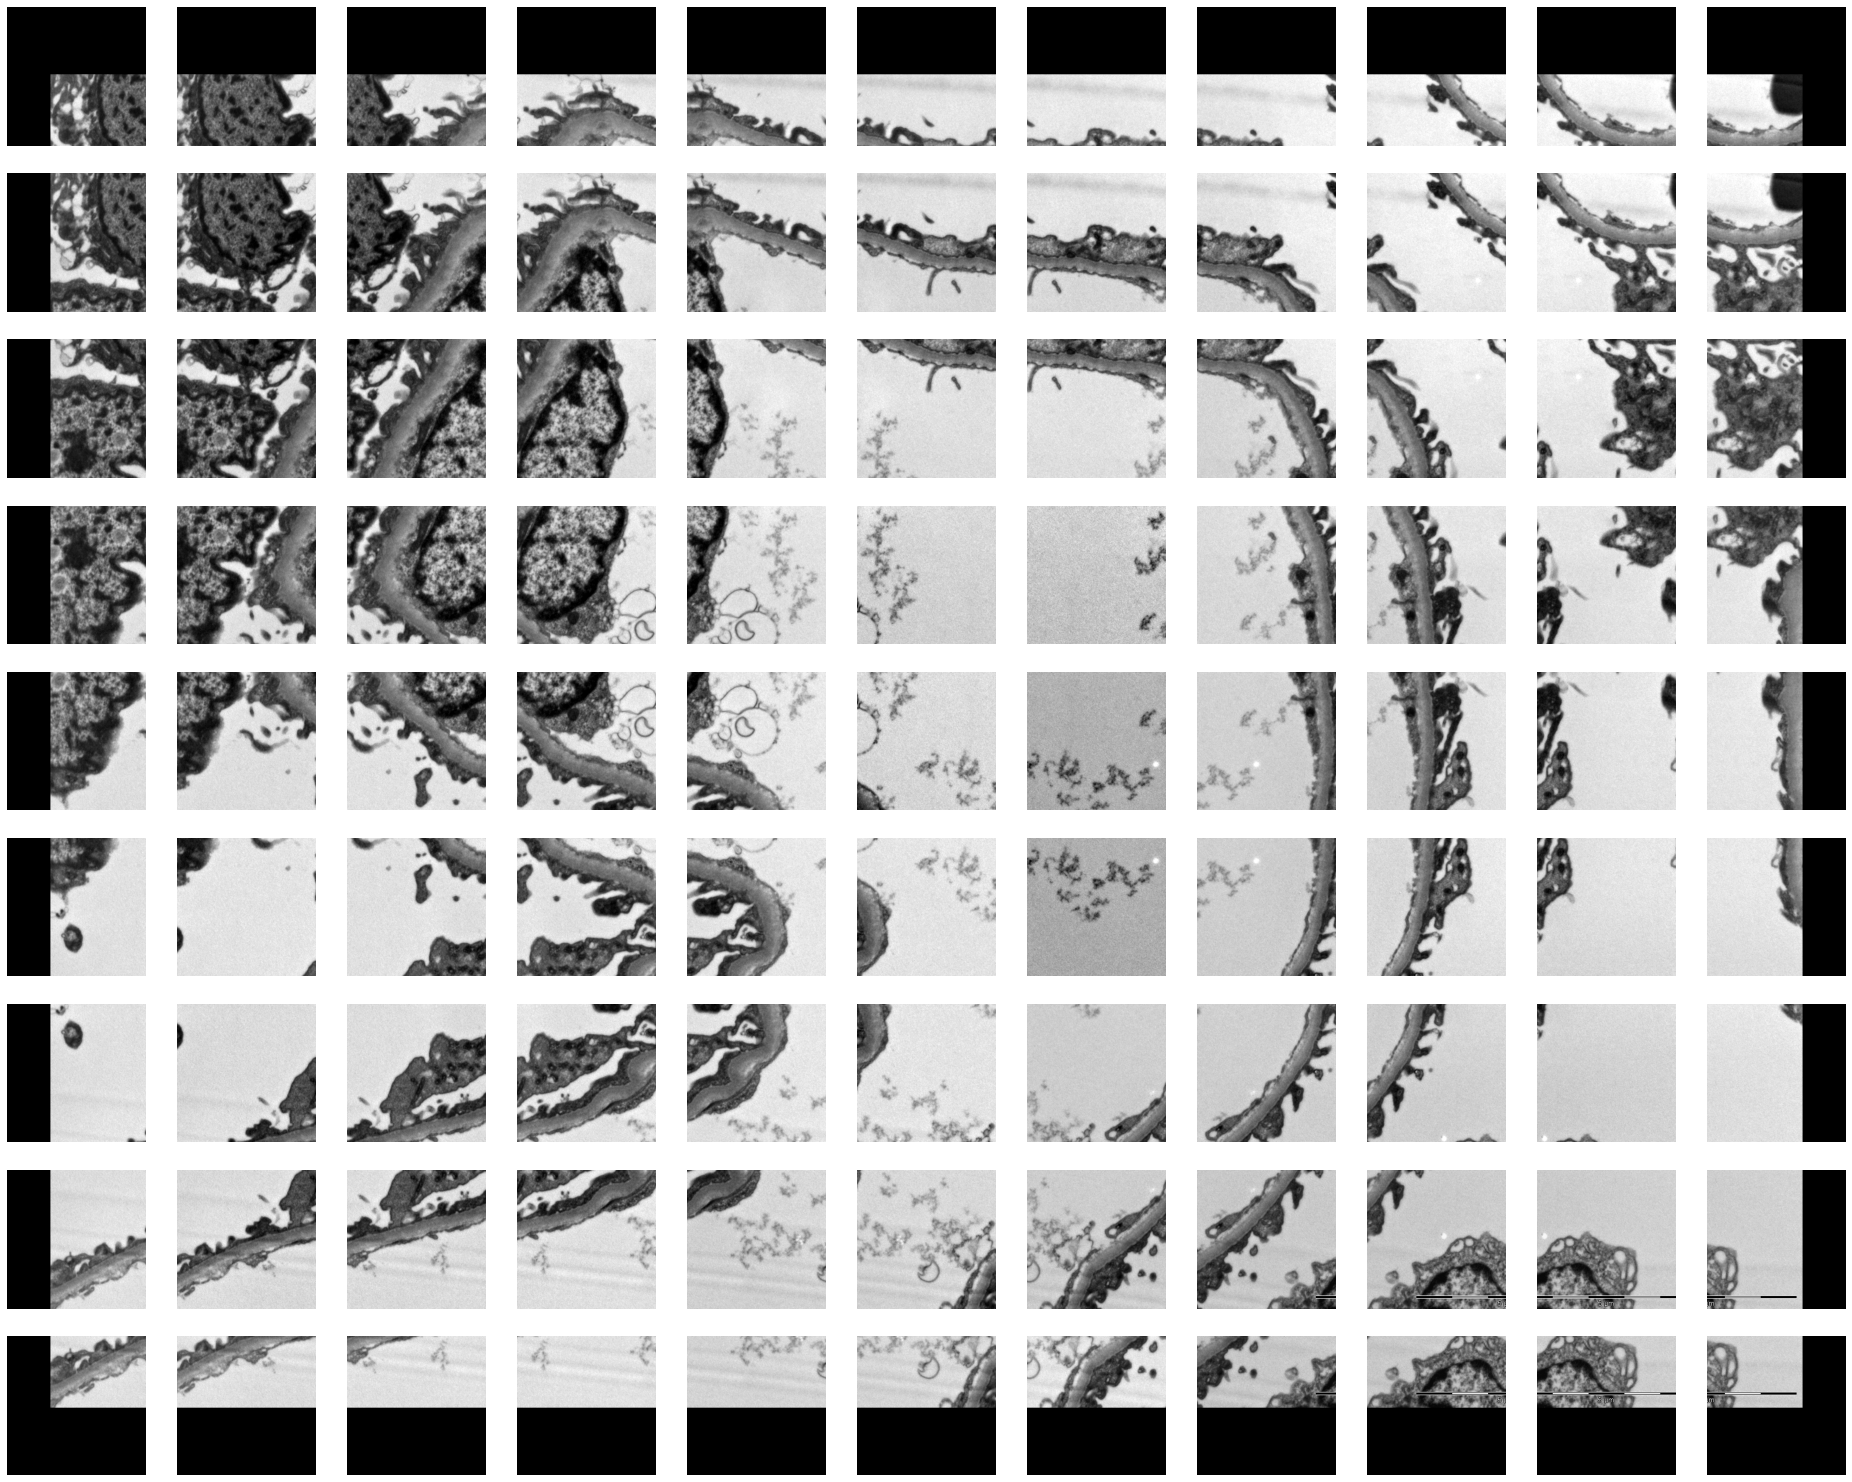

In [4]:
h, w, *_ = patches.shape
fig, axes = plt.subplots(nrows=h, ncols=w, figsize=(w*3, h*3))

for i in range(h):
    for j in range(w):
        axes[i, j].imshow(patches[i, j], cmap='gray')
        axes[i, j].axis('off')